<a href="https://colab.research.google.com/github/markyleangela/CNN-Projects/blob/main/Transfer_Learning_cat_breeds_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://huggingface.co/datasets/navhci/cat-breed-class

Cloning into 'cat-breed-class'...
remote: Enumerating objects: 1867, done.
remote: Total 1867 (delta 0), reused 0 (delta 0), pack-reused 1867 (from 1)
Receiving objects: 100% (1867/1867), 268.71 KiB | 3.58 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (1828/1828), done.
Filtering content: 100% (1827/1827), 51.78 MiB | 6.85 MiB/s, done.


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.models import Model
from keras.applications import ResNet50V2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import pandas as pd
import requests
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import img_to_array, array_to_img, load_img

In [3]:
import os
labels = os.listdir("cat-breed-class")  # Replace with your dataset name
print(labels)


['validation', '.gitattributes', '.git', 'training']


In [34]:
input_dir = "cat-breed-class/training"
output_dir = "cat-breed-class/augmented_training"

os.makedirs(output_dir, exist_ok=True)

In [5]:
datagen = ImageDataGenerator(
    rotation_range=30,  # Rotate images randomly
    width_shift_range=0.2,  # Shift width
    height_shift_range=0.2,  # Shift height
    shear_range=0.2,  # Shear
    zoom_range=0.2,  # Zoom
    horizontal_flip=True,  # Flip horizontally
    fill_mode="nearest"  # Fill missing pixels
)

In [6]:
#this is to extend the training data
# Loop through each class in dataset
from tensorflow.keras.utils import img_to_array, array_to_img, load_img

for class_name in os.listdir(input_dir):
    class_path = os.path.join(input_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip non-folder files

    # Create corresponding output folder
    save_path = os.path.join(output_dir, class_name)
    os.makedirs(save_path, exist_ok=True)

    # Process each image in the class folder
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)

        # Load and convert image
        img = load_img(img_path)  # Load image
        img_array = img_to_array(img)  # Convert to NumPy array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Generate and save augmented images
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=save_path, save_prefix="aug", save_format="jpg"):
            i += 1
            if i >= 5:  # Generate 5 augmented images per original image
                break  # Stop after generating the required number


In [7]:
import math
# Load Training Data
train_dataset = tf.keras.utils.image_dataset_from_directory( # use the train data with augmented data
    "cat-breed-class/augmented_training",  # Correct path
    image_size=(224, 224),
    batch_size=32
)

# Load Validation Data
val_dataset = tf.keras.utils.image_dataset_from_directory(
    "cat-breed-class/validation",  # Correct path
    image_size=(224, 224),
    batch_size=32
)


Found 5694 files belonging to 4 classes.
Found 600 files belonging to 4 classes.


In [32]:
class_names = os.listdir(input_dir)
print(class_names)

['persian', 'abyssian', 'toyger', 'munchkin']


In [9]:
import collections
class_names = train_dataset.class_names

# Count samples per class
label_counts = collections.Counter()
for _, labels in train_dataset:
    for label in labels.numpy():
        label_counts[class_names[label]] += 1

# Print class distribution
for class_name, count in label_counts.items():
    print(f"{class_name}: {count} samples")

persian: 1500 samples
munchkin: 1348 samples
abyssian: 1457 samples
toyger: 1389 samples


In [10]:

# Get class names
class_names = val_dataset.class_names

# Count samples per class
label_counts = collections.Counter()
for _, labels in val_dataset:
    for label in labels.numpy():
        label_counts[class_names[label]] += 1

# Print class distribution
for class_name, count in label_counts.items():
    print(f"{class_name}: {count} samples")

munchkin: 94 samples
abyssian: 187 samples
persian: 202 samples
toyger: 117 samples


In [11]:

# Get the number of batches in validation dataset
val_batches = len(val_dataset)  # Number of batches
test_batches = math.ceil(0.2 * val_batches)  # 20% of validation

# Split dataset
test_dataset = val_dataset.take(test_batches)  # Take first 20% for testing
val_dataset = val_dataset.skip(test_batches)  # Remaining 80% for validation

In [12]:
print(len(train_dataset)) #total sample / 32 (batch_size)  = total batches
print(len(val_dataset))
print(len(test_dataset))


178
15
4


In [13]:
def preprocess(image, label):
    final_image = tf.keras.applications.resnet_v2.preprocess_input(image)  # Normalize the images to required pixels of resnet_v2
    return final_image, label


In [14]:
train_dataset = train_dataset.shuffle(100) # shuffle every 100 images in the train dataset
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [15]:
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",  # Pretrained on ImageNet
    input_shape=(224, 224, 3),  # Input image size
)


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:


model = base_model.output
model = GlobalAveragePooling2D()(model)  #
model = Dense(128, activation="relu")(model)
model = Dropout(0.4)(model)
output_layer = Dense(4, activation="softmax")(model)  # Final classification layer

model = Model(inputs=base_model.input, outputs=output_layer)


In [17]:
for layer in base_model.layers: #freeze
  layer.trainable = False

In [18]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])


history = model.fit(train_dataset,
                    epochs=5,
                    validation_data=val_dataset,
                    verbose=1)


Epoch 1/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 1016s 6s/step - accuracy: 0.7489 - loss: 0.6484 - val_accuracy: 0.9258 - val_loss: 0.2131
Epoch 2/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 1041s 6s/step - accuracy: 0.8979 - loss: 0.2764 - val_accuracy: 0.9068 - val_loss: 0.2506
Epoch 3/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 1040s 6s/step - accuracy: 0.9294 - loss: 0.1898 - val_accuracy: 0.9216 - val_loss: 0.2065
Epoch 4/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 1042s 6s/step - accuracy: 0.9387 - loss: 0.1521 - val_accuracy: 0.9110 - val_loss: 0.2472
Epoch 5/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 1037s 6s/step - accuracy: 0.9547 - loss: 0.1233 - val_accuracy: 0.9004 - val_loss: 0.3110


In [39]:
predictions = model.predict(test_dataset, verbose=1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


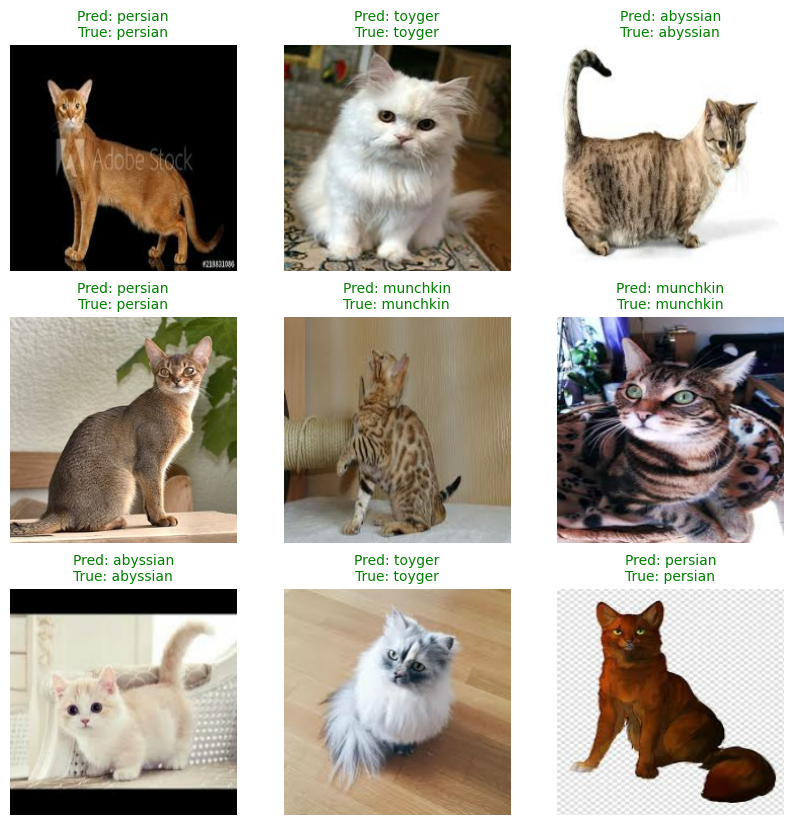

In [42]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np


for images, true_labels in test_dataset.take(1):
    break

predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Rescale images for visualization
images = (images + 1.0) / 2.0  # Convert from [-1, 1] to [0, 1] range because ResNetV2 normalized the values


plt.figure(figsize=(10, 10))
for i in range(min(9, len(images))):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.axis("off")

    # Display predicted and actual labels
    true_label = class_names[true_labels[i].numpy()]  # Convert tensor to label name
    pred_label = class_names[predicted_labels[i]]

    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=10, color="green" if pred_label == true_label else "red")

plt.show()
